# Workshop open antwoorden analyseren met NLP

Vandaag ga je aan de slag met het analyseren van open antwoorden. Deze bevatten vaak heel veel interessante informatie maar die is lastig om automatisch en op grote schaal uit de data te halen.

Eerst moeten we de nodige libraries importeren die ons helpen bij het verwerken en analyseren van de gegevens. Spacy is een taalverwerkings libary, terwijl de TfidfVectorizer van scikit-learn ons helpt de TF-IDF scores van woorden te berekenen. De WordCloud bibliotheek zal worden gebruikt om onze resultaten visueel weer te geven.

## Installations

!pip install spacy
!python -m spacy download en_core_web_lg
!pip install spacy_langdetect
!pip install gensim
!pip install nltk
!pip install wordcloud

## Imports

In [1]:
import csv
import string
import re
import nltk
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
import scipy.sparse as sp

from wordcloud import WordCloud
from gensim.models import word2vec
from sklearn import cluster, metrics
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from scipy.sparse._csr import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from spacy.lang.nl.examples import sentences
from spacy import displacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

nlp = spacy.load("en_core_web_lg")

## Load data

In [236]:
# Load data.
df = pd.read_csv('data/Restaurant_Reviews.tsv', sep='\t')

# Rename the columns.
df = df.rename(columns={
    'Review': 'review',
    'Liked': 'label'
})

# DEEL 1: ASPECT ANALYSE

## Stap 1: EDA (Exploratory Data Analysis)

We hebben de dataset ingeladen en voor we verder gaan met de data, willen we eerst meer over de dataset te weten komen, bijvoorbeeld hoe lang de gemiddelde review is. Reviews die heel kort zijn bevatten vaak te weinig informatie om automatisch te bepalen waar ze over gaan. Deze kunnen dan het beste uit de data worden gefilterd.

### General information & statistics

In [237]:
df.head()

,review,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1


In [238]:
num_rows = df.shape[0]
df.shape

(1000, 2)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [240]:
df['label'].value_counts()

1    500
0    500
Name: label, dtype: int64

### The number of characters in the reviews

In [241]:
max_characters = df['review'].str.len().max()
min_characters = df['review'].str.len().min()
mean_characters = df['review'].str.len().mean()

print(f'The review with the highest number of characters contains {max_characters} characters.')
print(f'The lowest number of characters is {min_characters} characters.')
print(f'The average is {mean_characters} characters.')

The review with the highest number of characters contains 149 characters.
The lowest number of characters is 11 characters.
The average is 58.315 characters.


In [242]:
pd.options.display.max_colwidth = int(max_characters + 1)
print(df['review'][df['review'].str.len() == max_characters])
print()
print(df['review'][df['review'].str.len() == min_characters])

985    The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).
Name: review, dtype: object

165    DELICIOUS!!
479    I LOVED it!
581    Over rated.
648    Great food.
663    Both great!
Name: review, dtype: object


### The number of words in the reviews

In [243]:
df['review'] = df['review'].str.strip() # Remove leading and trailing spaces.
max_words = df['review'].str.split().str.len().max() # Count the number of spaces and add 1 to find the number of words.
min_words = df['review'].str.split().str.len().min()
mean_words = df['review'].str.split().str.len().mean()

print(f'The review with the highest number of words contains {max_words} words.')
print(f'The lowest number of words contains {min_words} word.')
print(f'The average number of words is {mean_words} words.')

The review with the highest number of words contains 32 words.
The lowest number of words contains 1 word.
The average number of words is 10.894 words.


In [244]:
print(df['review'][df['review'].str.split().str.len() == max_words])
print()
print(df['review'][df['review'].str.split().str.len() == min_words])

623    a drive thru means you do not want to wait around for half an hour for your food, but somehow when we end up going here they make us wait and wait.
795     So good I am going to have to review this place twice - once hereas a tribute to the place and once as a tribute to an event held here last night.
Name: review, dtype: object

165    DELICIOUS!!
Name: review, dtype: object


### Vraag 1

Welke waardes heb je zojuist geprint? Hoe groot denk je dat deze waardes moeten zijn om de review nuttig te laten zijn?

In [245]:
df = df[df['review'].str.split().str.len() > 10]
print(f'{num_rows - df.shape[0]} reviews have been removed because they contain 10 words or less.')
print(f'There are {df.shape[0]} reviews left.')

556 reviews have been removed because they contain 10 words or less.
There are 444 reviews left.


## Stap 2: Filteren van zelfstandige naamwoorden, eigennamen en werkwoorden

Om de reviews te analyseren en de onderwerpen te ontdekken waarover ze vooral gaan, voeren we een TF-IDF analyse uit. Alleen zelfstandige naamwoorden, eigennamen en werkwoorden worden geanalyseerd omdat zelfstandige naamwoorden en eigennamen vaak de meest informatieve delen van een zin zijn. Werkwoorden daarentegen, zijn extra belangrijk omdat ze veel informatie geven over acties, gebeurtenissen en toestanden.

Om variatie te verminderen worden de zelfstandige naamwoorden en werkwoorden van elke tekst teruggebracht tot hun basisvorm (lemma). Sommige vaak voorkomende woorden die niet informatief zijn voor de analyse worden verwijderd. Dit doen we om ruis uit de data te verwijderen en alleen de informatie te behouden die interessant is voor de analyse. In het geval van de restaurant reviews worden vaak voorkomende gerechten veranderd naar menu_item, zodat ons model deze later allemaal als hetzelfde soort woord ziet.

Voor het bepalen van de woordsoorten, stopwoorden en lemma's gebruiken we spacy. Dit is een speciale library voor NLP die beschikbaar is in veel verschillende talen.

In [246]:
dishes = [
    "Spaghetti", "Chicken Curry", "Beef Steak", "Fish Stew", "Lamb Chops", "Ramen", "Soup",
    "Rice Bowl", "Tacos", "Burritos", "Hamburger", "Pizza", "Lobster Soup", "Clam Soup",
    "Salad", "Eggs", "Bread", "Duck Roast", "Noodles", "Falafel", "Sushi", "Fried Vegetables",
    "Fried Chicken", "Stew", "Vegetable Mix", "Rice Pilaf", "Seafood Rice", "Fish Salad",
    "Cheese Fries", "Tofu Soup", "Grilled Chicken", "Meat Wrap", "Dumplings", "Raw Fish",
    "Toasted Bread", "Pasta", "Lamb Curry", "Meat Pie", "Chicken Waffles", "Chicken Wrap",
    "Dough Pockets", "Chili", "Beef Stroganoff", "Nachos", "Filled Pasta", "Cheese Wrap",
    "Layered Meat", "Avocado Dip", "Stir Fry", "Roast Beef", "Beef Wrap", "Steamed Bread",
    "Breakfast Platter", "Chicken Curry", "Buttered Chicken", "Steak and Fries",
    "Grilled Salmon", "Pancakes", "Waffles", "Shrimp Pasta", "Rice and Meat", "Seafood Soup",
    "Mixed Salad", "Stuffed Peppers", "Deep Fried Burrito", "Seafood Pasta", "Sandwich",
    "Onion Soup", "Spicy Soup", "Eggs in Sauce", "Cabbage Meat Roll", "Fried Eggs",
    "Sweet Bread", "Meat Hash", "Spicy Chicken", "Sweet Chicken", "Chicken Rolls",
    "Pork Sandwich", "Chicken Pie", "Fried Tofu", "Steamed Meat", "Meat Sandwich",
    "Grilled Sandwich", "Meat Pastry", "Grilled Ribs", "Roasted Meat", "Sausages and Mash",
    "Fish Wrap", "Pasta Rolls", "Stir Fry Noodles", "Steamed Lobster", "Roast Meat",
    "Baked Oysters", "Grilled Rib", "Pot Rice", "Cornbread", "Slow-cooked Beef",
    "Filled Pastry", "Olive Spread", "Corn Soup", "Filled Eggs", "Seared Scallops",
    "Fried Dough", "Fried Potatoes", "Roasted Chicken", "Meat Burrito", "Meat Curry",
    "Braised Meat", "Mushroom Chicken", "Potato Dumplings", "Meat Skewers", "Fish Cakes",
    "Melted Sandwich", "Chicken Soup", "Meat Sauce", "Garlic Pasta", "Breaded Seafood",
    "Grilled Pork", "Beet Salad", "Tomato Soup", "Grilled Meat", "Cabbage Salad",
    "Seafood Salad", "Cheese Quesadilla", "Baked Pasta", "Grilled Sausage", "Yogurt Dip",
    "Creamy Soup", "Cheese Rice", "Grilled Wrap", "Fish Grill", "Fried Rice",
    "Stacked Sandwich", "Fish Salad", "Tomato Salsa", "Meat Dip Sandwich", "Egg Pie",
    "Toasted Garlic Bread", "Potato Sides", "Cheese Pasta", "Chicken Wrap", "Seafood Roll",
    "Meat Dumplings", "Fried Veal", "Turkey Roast", "Veggie Sandwich", "Creamy Risotto",
    "Chicken Skewers", "Baked Potato", "Lemon Chicken", "Grilled Veggies", "Potato Pasta",
    "Seafood Fry", "Spinach Pastry", "Cheesy Nachos", "Mixed Paella", "Chicken Wings",
    "Duck Wraps", "Potato Mix", "Grilled Skewers", "Burger", "Pho", "Butter", "Chicken",
]

# Manually found these dishes.
#'''
dishes += [
    "sushi", "potato", "burger", "tacos", "pizza", "fries", "pizzas",
    "salad", "greek salad", "chicken", "bread", "butter", "potato chips",
    "bacon", "scallop", "saffron", "wings", "ice cream", "pasta",
    "burgers", "naan bread", "pita", "hummus", "pine nut sauce", "salads",
    "sandwiches", "pho", "beer", "beef", "pepper", "auja", "baklava",
    "falafels", "baba ganoush", "eggplant", "vinegrette", "meatloaf",
    "wrap", "tuna", "soup", "tomato"
]
#'''

dishes = [dish.lower() for dish in dishes]

In [247]:
def filter_words(df: pd.DataFrame(), column_name: str, dishes: list) -> pd.DataFrame():
    '''
    Filter words out of the DataFrame column that contains the restaurent reviews.
    
    Args:
        df (DataFrame): The input DataFrame containing the reviews.
        column_names (str): The column names that contains the reviews.
        dishes (list): A list of dishes. All dishes will be replaced with the string 'menu_item', 
            which will make sure the model does not develop a bias based on the dish.
    
    Returns:
        df (DataFrame): The same DataFrame but now with only the important words remaining.
    '''
    
    processed_reviews_list = []
    
    for i, review in enumerate(df[column_name]):
        tokens = []
        for token in nlp(review):
            # Make sure the word is either a noun, propn or verb, and is not a stop word.
            if (token.pos_ in ["NOUN", "PROPN", "VERB"]) and (not token.is_stop):
                if token.lemma_ in dishes:
                    tokens.append('menu_item')
                else:
                    tokens.append(token.lemma_)
        processed_reviews_list.append(' '.join(tokens))
                
    df['processed_review'] = processed_reviews_list
    
    return df

df = filter_words(df=df, column_name='review', dishes=dishes)    

In [248]:
# Taking a look at which words are left.
df[['review', 'processed_review']].head(20)

,review,processed_review
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,stop bank holiday Rick Steve recommendation love
4,The selection on the menu was great and so were the prices.,selection menu price
5,Now I am getting angry and I want my damn pho.,get want damn menu_item
7,The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.,menu_item rubber tell time keep
12,The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.,cashier care end wayyy
14,I was disgusted because I was pretty sure that was human hair.,hair
27,"This hole in the wall has great Mexican street tacos, and friendly staff.",hole wall street taco staff
28,"Took an hour to get our food only 4 tables in restaurant my food was Luke warm, Our sever was running around like he was totally overwhelmed.",took hour food table restaurant food Luke sever run
30,"Also there are combos like a burger, fries, and beer for 23 which is a decent deal.",combo menu_item fry menu_item deal
32,I found this place by accident and I could not be happier.,find place accident


### Taking a look at how many dishes have been replaced with 'menu_item'

In [249]:
count_menu_item = 0
for list_of_words in df['processed_review']:
    list_of_words = list_of_words.split()
    for word in list_of_words:
        if word == 'menu_item':
            count_menu_item += 1

print(f'{count_menu_item} dishes have been replaced with the word "menu_item".')

117 dishes have been replaced with the word "menu_item".


### Vraag 2

Waarom is het nuttig om stopwoorden te verwijderen in tekstverwerking en analyse?

## Stap 3: TF-IDF algoritme toepassen

We passen de TF-IDF analyse toe. TF-IDF (Term Frequency-Inverse Document Frequency) is een statistische maat die aangeeft hoe belangrijk een woord is voor een document in een collectie of corpus. We berekenen deze scores voor onze verwerkte reviews.

In [250]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_review'])
X

<444x876 sparse matrix of type '<class 'numpy.float64'>'
	with 2139 stored elements in Compressed Sparse Row format>

Dus er zijn in totaal 444 reviews, bij elkaar hebben die 2161 woorden en 890 unieke woorden.

Om de sparse matrix dense te maken kan je het volgende doen.

In [251]:
tfidf_tokens = vectorizer.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = X.toarray(), columns = tfidf_tokens)
df_tfidfvect.head()

,30,accident,accommodation,accomodate,accountant,ache,acknowledge,add,airport,ala,...,world,worry,wound,write,ya,yama,year,yelpers,yukon,yum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Vraag 3

Waarom zou je TF-IDF gebruiken in plaats van alleen termfrequentie (TF) om de belangrijkheid van woorden te beoordelen?

## Stap 4: WordCloud van de Meest Voorkomende Woorden en van de woorden met de hoogste TF-IDF score

Om een visueel overzicht te krijgen van welke woorden het meest voorkomen in onze reviews, genereren we een wordcloud. Hoe groter een woord wordt weergegeven, hoe vaker het voorkomt.

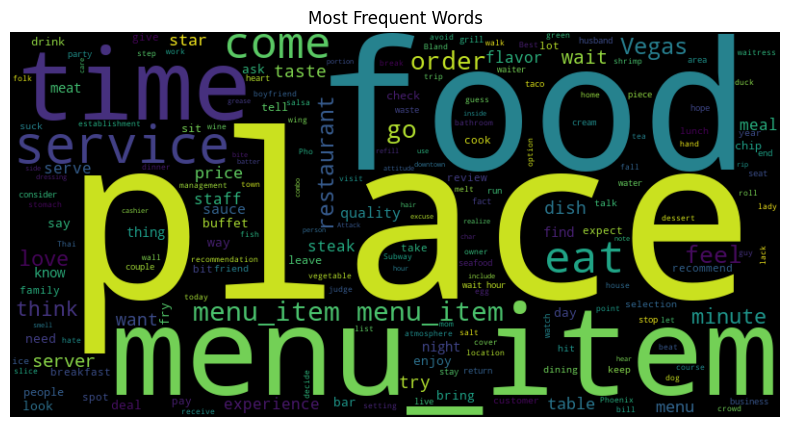

In [252]:
def plot_wordcloud(column: pd.Series) -> None:
    '''
    Plot a wordcloud based on a column in a Pandas DataFrame.
    The column should contain words as a string separated by spaces.
    
    Args:
        column (pd.Series): The column in the Pandas DataFrame containing the words to plot.
    
    Returns:
        None
    '''
    
    word_freq = ' '.join(column)
    wordcloud = WordCloud(width=800, height=400).generate(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Most Frequent Words")
    plt.show()

plot_wordcloud(df['processed_review'])

### Vraag 4

Hoe zou de wordcloud eruit zien wanneer je deze maakt van de niet voorbewerkte reviews?
Je kunt dit uitproberen in de cel hieronder

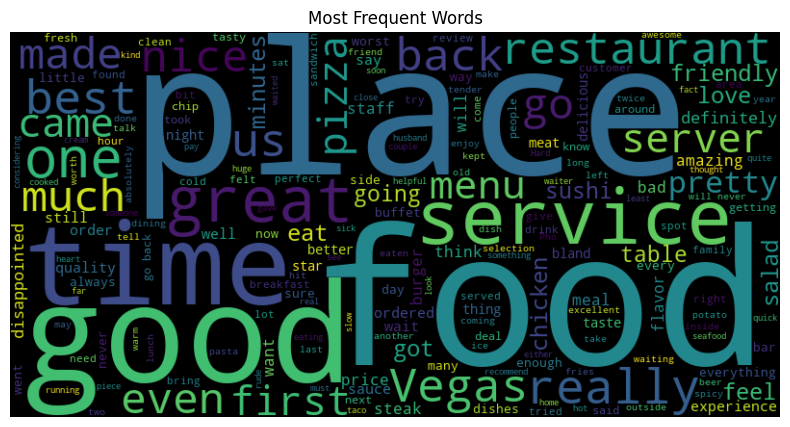

In [253]:
plot_wordcloud(df['review'])

Nu genereren we een andere wordcloud, maar deze keer op basis van de TF-IDF scores. Dit geeft ons een beeld van welke woorden uniek informatief zijn voor de reviews in onze dataset.

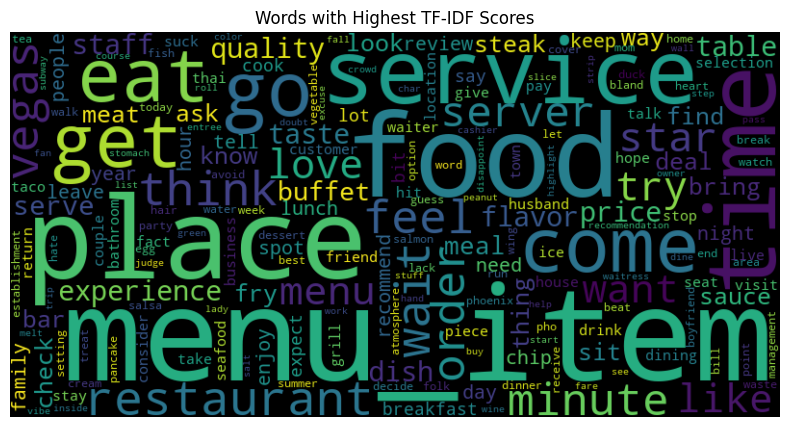

In [254]:
def plot_wordcloud_from_frequencies(frequency_dictionary: dict) -> None:
    '''
    Plot a wordcloud based on frequency values in a dictionary.
    
    Args:
        frequency_dictionary (dict): The dictionary containing the 
            frequency values for each word.
    
    Returns:
        None
    '''
    
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequency_dictionary)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Words with Highest TF-IDF Scores")
    plt.show()

# Get the feature names.
feature_names = vectorizer.get_feature_names_out()

# Take to sum of the columns (the sum of the TF-IDF scores for each word over all documents/reviews).
# Sort them descending, take the indices instead of the TF-IDF scores, and convert them to a list.
sorted_indices = X.sum(axis=0).argsort()[0, ::-1].tolist()[0]

# Obtain TF-IDF scores using a dictionary comprehension.
# Because your indices are sorted, Your TF-IDF scores are also sorted from high to low.
tfidf_scores = {feature_names[i]: X.sum(axis=0)[0, i] for i in sorted_indices}

# Plot the results.
plot_wordcloud_from_frequencies(tfidf_scores)

### For comparison

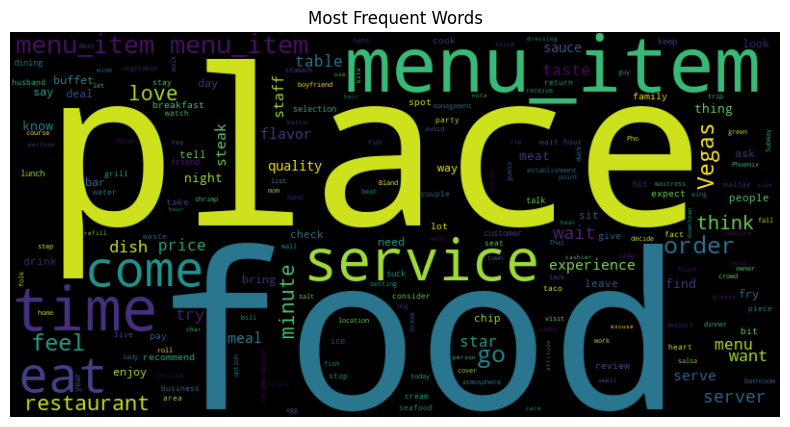

In [255]:
plot_wordcloud(df['processed_review'])

### Vraag 5

Hoe verschillen de woorden die worden getoond in de TF-IDF wordcloud van die in de frequentie wordcloud, en waarom?

## Stap 5: Het bepalen van het optimale nummer van clusters

Nu dat we een beter idee hebben gekregen over waar de reviews over gaan, willen we automatisch gaan bepalen welke review waarover gaat. Dit zou je kunnen doen door alle reviews handmatig te labellen. Omdat dit veel werk is en erg lang duurt wordt er binnen de NLP ook soms gebruik gemaakt van unsupervised methodes om teksten in onderwerpen in te delen. In deze workshop gaan we aan de slag met KMeans clustering.

KMeans clustering is een van de meest gebruikte en bekende niet-hiërarchische clusteringmethoden. Het doel van clustering is om datapunten te groeperen op basis van hun gelijkenissen, zonder dat er vooraf gedefinieerde labels beschikbaar zijn (zoals bij supervised learning).

**Hoe werkt KMeans clustering?**

Initiatie van Centroids: De algoritme start door kk initial centroids te kiezen. kk is het aantal clusters dat je wilt hebben en dit is een waarde die je zelf moet opgeven. De initiële centroids worden vaak willekeurig gekozen uit de datapunten. 

Toewijzen van Datapunten: Elk datapunt wordt toegewezen aan het dichtstbijzijnde centroid, en zo vormen er zich k clusters.

Herberekening van Centroids: Nadat alle datapunten zijn toegewezen, wordt het gemiddelde van de datapunten in een cluster genomen, en dit gemiddelde wordt de nieuwe positie van het centroid.

Herhalen: Stappen 2 en 3 worden herhaald totdat de centroids niet meer veranderen (of tot een andere stopconditie bereikt is).

Belangrijke Opmerkingen:
- De waarde van kk (aantal clusters) moet van tevoren gespecificeerd worden. Het kiezen van een optimale k kan soms een uitdaging zijn, maar methoden zoals de "elbow method" kunnen helpen. 
- KMeans kan gevoelig zijn voor de initiële plaatsing van centroids. Hierdoor kan het soms leiden tot verschillende resultaten bij verschillende uitvoeringen als de initiële centroids willekeurig worden gekozen. Er zijn geavanceerdere methoden om dit te overkomen, zoals KMeans++ dat zorgt voor een slimmere initiële plaatsing van centroids.
- Het algoritme werkt het best wanneer clusters bolvormig zijn en ongeveer dezelfde grootte hebben. Als clusters langgerekt zijn of als een cluster veel groter is dan een ander, kan KMeans moeite hebben om goed te presteren.

**De Elbow method**

Voor we de data gaan onderverdelen, willen we weten wat het meest geschikte nummer van clusters is. Dit doen we aan de hand van de Elbow method. De Elbow Method helpt bij het vinden van het optimale aantal clusters voor KMeans door de som van de kwadratische afwijkingen (SSE) voor een reeks waarden van k (aantal clusters) te berekenen. Wanneer de SSE begint af te vlakken en een "elleboog" vormt, geeft dat het optimale aantal clusters aan.

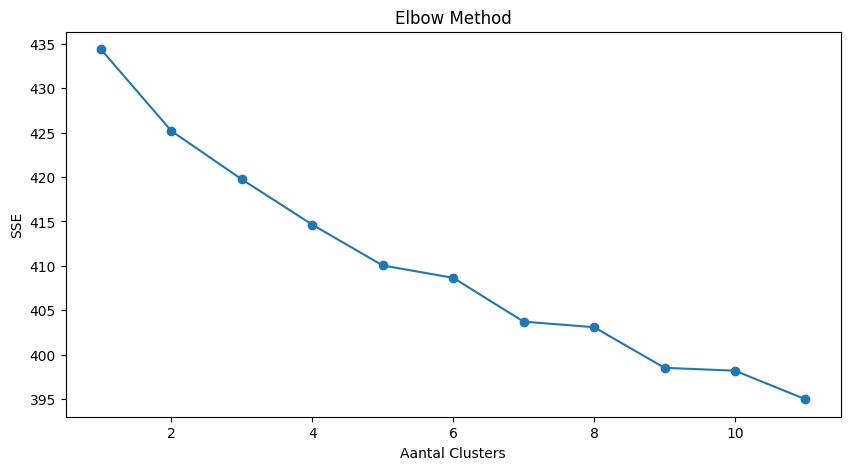

In [256]:
def plot_SSE_kmeans_clusters(X: csr_matrix, cluster_range: range) -> None:
    '''
    Plot the SSE for clustering when using different values for k.
    
    Args:
        X (csr_matrix): Scipy spars matrix containing thet TF-IDF values.
        cluster_range (range): The range for the k_values.
    
    Returns:
        None
    '''
    
    sse = []
    possible_k_values = cluster_range
    
    # Get the SSE values for each k-value.
    for k in possible_k_values:
        kmeans = KMeans(n_clusters=k, random_state=64)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    
    # Plot the results.
    plt.figure(figsize=(10, 5))
    plt.plot(possible_k_values, sse, marker='o')
    plt.xlabel('Aantal Clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()

cluster_range = range(1, 12)
plot_SSE_kmeans_clusters(X=X, cluster_range=cluster_range)

In het plaatje kun je zien dat er meerdere knikjes zitten in de plot. De duidelijkste elleboog is te zien bij K=9. Daarom gaat we verder met K=9.

### Find the best number of clusters with the Silhouette score.

In [257]:
def optimize_kmeans(X: csr_matrix, cluster_range: range) -> (int, float):
    '''
    Find the best k-value using the Silhouette score.
    
    Args:
        X (csr_matrix): Scipy spars matrix containing thet TF-IDF values.
        cluster_range (range): The range for the k_values.
    
    Returns:
        None
    '''
    
    best_score = -1  # Begin met de laagst mogelijke score.
    best_k = None  # Het beste aantal clusters.

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        score = silhouette_score(X, kmeans.labels_)

        # Get the score and k-value for the highest Silhouette score.
        if score > best_score:
            best_score = score
            best_k = k

    return best_k, best_score

cluster_range = range(2, 11)
best_k, best_score = optimize_kmeans(X, cluster_range)

print(f"\nOptimale aantal clusters: {best_k} met silhouette score: {best_score}.")
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
clusters = kmeans.fit_predict(X)
df['cluster'] = clusters


Optimale aantal clusters: 10 met silhouette score: 0.026479122516621087.


## Stap 6: KMeans clustering uitvoeren en visualiseren van de clusters

Gebruik KMeans clustering met het gekozen aantal clusters (gebaseerd op de Elbow Method).

Vervolgens willen we onze bepaalde clusters visualiseren. Hiervoor moeten we eerst het aantal dimensies terugbrengen naar 2, om een 2d plaatje te genereren. Dit door we met behulp van Principal Component Analysis (PCA).

### Vraag 6

Hoeveel dimensies hebben de vectoren voordat we PCA hebben toegepast.

In [258]:
### type hier je code
X

<444x876 sparse matrix of type '<class 'numpy.float64'>'
	with 2139 stored elements in Compressed Sparse Row format>

Ik denk 891 dimensies, omdat alle 444 reviews bij elkaar 891 unieke woorden bevatten, en voor elke review/document is er een vector die de TF-IDF score weergeeft voor elk van die woorden.

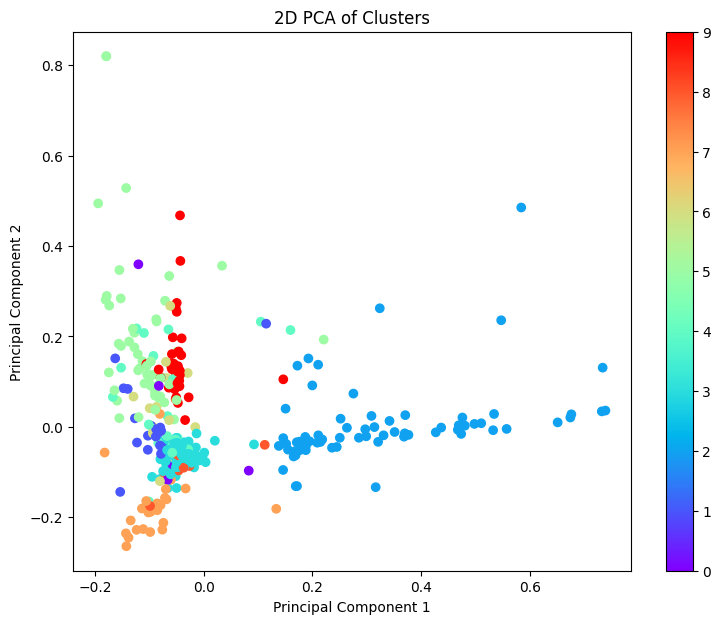

In [259]:
def plot_pca_clusters(X: csr_matrix, clusters: np.ndarray, n_dim=2) -> None:
    '''
    Apply Principal Component Analysis (PCA) and plot the results to visualize the clusters.
    
    Args:
        X (csr_matrix): Scipy spars matrix containing thet TF-IDF values.
        clusters (np.ndarray): A list containing all the clusters for each document/review.
        n_dim (int): The number of dimensions to reduce to, using PCA (default=2).

    Returns:
        None
    '''
    
    pca = PCA(n_components=n_dim)
    reduced_features = pca.fit_transform(X.toarray())

    plt.figure(figsize=(9, 7))
    plt.scatter(reduced_features[:,0], reduced_features[:,1], c=clusters, cmap='rainbow')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('2D PCA of Clusters')
    plt.colorbar()
    plt.show()

plot_pca_clusters(X=X, clusters=clusters)

## Stap 7: Bepalen waar elk cluster over gaat

In deze stap willen we inzicht krijgen in de karakteristieken van elk cluster door de woorden te bekijken die het meest kenmerkend zijn voor elk cluster. Deze woorden worden bepaald door naar de clustercentra te kijken die door KMeans zijn berekend. De clustercentra zijn in feite de gemiddelde waarden van de features (in dit geval TF-IDF scores) van alle items in die cluster.

Voor elke cluster willen we de termen (of woorden) tonen die de hoogste waarden in deze centra hebben, omdat deze termen het meest kenmerkend zijn voor die cluster.

In [260]:
def get_most_occuring_terms_per_cluster(kmeans, vectorizer) -> pd.DataFrame():
    '''
    Print the most occuring terms in each cluster.
    
    Args:
        kmeans (sklearn.cluster._kmeans.KMeans): Your kmeans cluster variable.
        vectorizer (sklearn.feature_extraction.text.TfidfVectorizer): Your TF-IDF vectorizer.
    
    Returns:
        (pd.DataFrame()): A DataFrame containing the most occuring words per cluster.
    '''

    # Hier sorteren we de indices van de clustercentra in aflopende volgorde.
    # Dit betekent datdf[''] de belangrijkste termen (die met de hoogste TF-IDF scores) vooraan in de lijst komen.
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    # Haal de feitelijke termnamen op uit de vectorizer.
    terms = vectorizer.get_feature_names_out()

    # Loop door elke cluster en print de top 5 termen.
    cluster_terms = []
    for i in range(best_k):
        words = ''
        for ind in order_centroids[i, :5]:
            words += f'{terms[ind]} '
        cluster_terms.append(words)

    # Create cluster terms DataFrame.
    df = pd.DataFrame({'cluster_index': range(best_k), 'most_occuring_terms': cluster_terms})
    df = df.set_index('cluster_index', drop=True)
    
    return df

df_cluster_terms = get_most_occuring_terms_per_cluster(kmeans=kmeans, vectorizer=vectorizer)
df_cluster_terms

,most_occuring_terms
cluster_index,
0,star give review deserve rate
1,service server table come customer
2,menu_item get place taste love
3,try flavor staff buffet come
4,restaurant quality food service excuse
5,food service place wait minute
6,like leave want place waste
7,time go wait think server
8,menu drink price suggestion fact


In [261]:
# Inspect the number of reviews in each cluster.
df['cluster'].value_counts()

3    166
2     68
5     54
9     40
7     28
4     22
6     21
1     20
8     15
0     10
Name: cluster, dtype: int64

In [262]:
df_cluster_reviews = df.sort_values('cluster')
df_cluster_reviews = df_cluster_reviews[['review', 'cluster']]
df_cluster_reviews = df_cluster_reviews.set_index('cluster', drop=True)

# Change index value to see other clusters.
pd.options.display.max_rows = 500
df_cluster_reviews[df_cluster_reviews.index == 4]

,review
cluster,
4,"All in all an excellent restaurant highlighted by great service, a unique menu, and a beautiful setting."
4,"I was proven dead wrong by this sushi bar, not only because the quality is great, but the service is fast and the food, impeccable."
4,"This place is pretty good, nice little vibe in the restaurant."
4,We aren't ones to make a scene at restaurants but I just don't get it...definitely lost the love after this one!
4,The restaurant is very clean and has a family restaurant feel to it.
4,It sure does beat the nachos at the movies but I would expect a little bit more coming from a restaurant.
4,"This isn't a small family restaurant, this is a fine dining establishment."
4,The only redeeming quality of the restaurant was that it was very inexpensive.
4,"This place is not quality sushi, it is not a quality restaurant."


We hebben nu een globaal idee van de 8 clusters en waar deze clusters over gaan. Na inspectie van de data kunnnen we nu namen voor de clusters bedenken. Dit worden dan onze aspect labels die we vervolgens gaan toekennen aan de reviews.

Tijdens deze workshop zullen we de volgende clusternamen gebruiken:

- Cluster 0: overige comments
- Cluster 1: service
- Cluster 2: bediening
- Cluster 3: specifieke gerechten
- Cluster 4: hygiëne
- Cluster 5: wachttijd
- Cluster 6: specifieke gerechten
- Cluster 7: beoordeling
- Cluster 8: smaak

Zoals je kunt zien, gaan zowel cluster 3 als 6 over specifieke gerechten. Deze zullen we dan ook hetzelfde noemen in ons dataframe

# DEEL 2: SENTIMENTANALYSE

## Stap 8: Voorbereiden van de data voor het sentiment model

Voordat we het model trainen, moeten we de data voorbereiden. Dat betekent dat we de review en cluster naam aan elkaar moeten plakken en deze moeten omzetten naar een numerieke vorm die door het model kan worden verwerkt. Vervolgens verdelen we de data in een train en test set. We moeten de dataset verdelen in een trainings- en testset terwijl we de klasseverdeling behouden. Met stratified sampling zorgen we ervoor dat de verhouding van positieve en negatieve sentiment labels in de trainings- en testsets gelijk is aan de verhouding in de gehele dataset.

In [265]:
# Create with the processed review and the cluster nume.
df['text'] = df['processed_review'] + ' ' + df['cluster_name_english']

# Create train and test sets with equal label distribution.
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.1,
    random_state=42,
    stratify=df['label']
)

In [266]:
len(X_train)

399

## Stap 9: Data vectorisatie met TF-IDF

De TF-IDF vectorizer transformeert tekst naar een numeriek formaat dat door ons model kan worden begrepen. Hierbij wordt rekening gehouden met de frequentie van woorden in documenten in vergelijking met hun frequentie in het hele corpus.

In [267]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Stap 10: Model opzetten en trainen

We zullen een MLP-classifier van scikit-learn gebruiken om de sentimenten te classificeren. Een Multi-layer Perceptron (MLP) is een klasse van feedforward kunstmatig neuraal netwerk. Het bestaat uit ten minste drie lagen knooppunten: een invoerlaag, een of meerdere verborgen lagen en een uitvoerlaag. Behalve voor de invoerknooppunten wordt elke knoop een neuron genoemd, dat een niet-lineaire activatiefunctie gebruikt.

**Structuur van een MLP:**
- Invoerlaag: Deze laag ontvangt de features van de dataset. Het aantal neuronen in deze laag komt overeen met het aantal features in de data.
- Verborgen lagen: Dit zijn lagen tussen de invoer- en uitvoerlagen. De complexiteit en capaciteit van het netwerk worden verhoogd door het toevoegen van meer verborgen neuronen en lagen. Elke neuron in een verborgen laag is verbonden met alle neuronen in de vorige en volgende lagen.
- Uitvoerlaag: Geeft de uiteindelijke voorspelling of classificatie van het netwerk weer. Het aantal neuronen hier is vaak gelijk aan het aantal te voorspellen klassen of uitkomsten.

**Activatiefuncties:**
Activatiefuncties zijn essentieel voor MLP's omdat ze het netwerk in staat stellen niet-lineaire relaties in de data te modelleren. Enkele veelgebruikte activatiefuncties zijn de sigmoid, tanh en ReLU.

**Backpropagation en training:**
MLP's worden getraind met een techniek genaamd backpropagation. Tijdens de training wordt de fout (verschil tussen de werkelijke en de voorspelde uitvoer) berekend en vervolgens wordt deze fout teruggepropageerd door het netwerk om de gewichten van de neuronen bij te werken.

**Waarom een MLP voor tekstclassificatie?**
MLP's kunnen nuttig zijn voor tekstclassificatie zoals aspect-gebaseerde sentimentanalyse vanwege hun vermogen om complexe niet-lineaire relaties in de data te identificeren en te leren. Door een netwerk met voldoende capaciteit te hebben, kunnen MLP's nuances in tekstdata vangen die misschien over het hoofd worden gezien door eenvoudigere modellen.

Het trainingsproces past de gewichten van het netwerk aan om de nauwkeurigheid van de voorspellingen te verbeteren.

In [271]:
mlp = MLPClassifier(hidden_layer_sizes=(11, 11, 11), max_iter=10000, random_state=42, batch_size=1)
mlp.fit(X_train_vec, y_train)

MLPClassifier(batch_size=1, hidden_layer_sizes=(11, 11, 11), max_iter=10000,
              random_state=42)

### Vraag 7

Wat vertegenwoordigen de getallen in hidden_layer_sizes=(10, 10, 10)?

### Vraag 8

Hoeveel output dimensies heeft onze MLP? Waar staan deze voor?

In [272]:
y_pred = mlp.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6222222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62        24
           1       0.58      0.67      0.62        21

    accuracy                           0.62        45
   macro avg       0.62      0.62      0.62        45
weighted avg       0.63      0.62      0.62        45



Je bent aan het einde gekomen van dit notebook. Door de aangegeven stappen te doorlopen heb je een model gebouwd wat met 62% nauwkeurigheid kan voorspellen waar een review over gaat en of hetgeen wat besproken wordt op een positieve of negatieve manier belicht wordt. Natuurlijk kan de performance nog verder verbeterd worden door het gebruik van meer geavanceerde modellen of het toevoegen van extra trainingsdata. Zie dit notebook daarom meer als uitleg over hoe aspect-based sentiment analysis werkt en ga hier zelf mee aan de slag.

Geïnteresseerd in hoe je met behulp andere klassieke machine learning of met transformer-based modellen een model voor zowel zero-shot and few-shot aspect-based sentiment classification kan bouwen? Kijk dan eens op: https://github.com/Lois1321998/ABSA_surveyresponses